In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# Load data
df = pd.read_csv("Coursera.csv")

# Preprocess data
df['Course Rating'] = pd.to_numeric(df['Course Rating'], errors='coerce')
df.dropna(subset=['Course Rating'], inplace=True)
df['Content'] = df['Course Description'] + " " + df['Skills']

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440 entries, 0 to 3521
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Course Name         3440 non-null   object 
 1   University          3440 non-null   object 
 2   Difficulty Level    3440 non-null   object 
 3   Course Rating       3440 non-null   float64
 4   Course URL          3440 non-null   object 
 5   Course Description  3440 non-null   object 
 6   Skills              3440 non-null   object 
 7   Content             3440 non-null   object 
dtypes: float64(1), object(7)
memory usage: 241.9+ KB


In [4]:
df.isnull().sum()

Course Name           0
University            0
Difficulty Level      0
Course Rating         0
Course URL            0
Course Description    0
Skills                0
Content               0
dtype: int64

In [5]:
df.duplicated().sum()

98

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
df['Difficulty Level'].value_counts()

Beginner          1387
Advanced           955
Intermediate       809
Conversant         143
Not Calibrated      48
Name: Difficulty Level, dtype: int64

In [9]:
df = df[df['Difficulty Level'] != 'Not Calibrated']

In [10]:
df['Difficulty Level'].value_counts()

Beginner        1387
Advanced         955
Intermediate     809
Conversant       143
Name: Difficulty Level, dtype: int64

In [11]:
df['Course Rating'].value_counts()

4.7    696
4.6    588
4.8    579
4.5    377
4.4    231
4.9    172
4.3    153
4.2    119
5.0     89
4.1     85
4.0     49
3.8     24
3.9     20
3.7     18
3.6     18
3.5     17
3.4     13
3.0     12
3.2      9
3.3      6
2.9      6
2.6      2
2.8      2
2.4      2
1.0      2
2.0      1
3.1      1
2.5      1
1.9      1
2.3      1
Name: Course Rating, dtype: int64

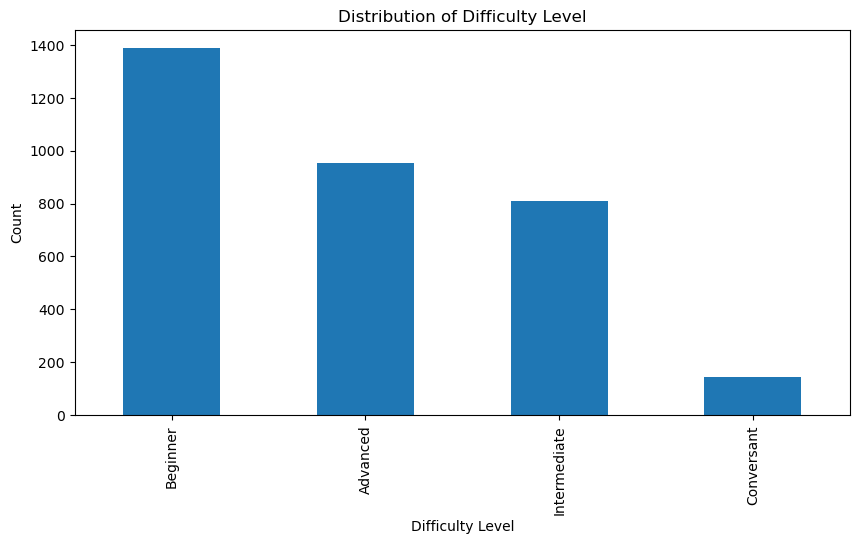

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title('Distribution of Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Count')
df['Difficulty Level'].value_counts().plot(kind='bar')
plt.show()

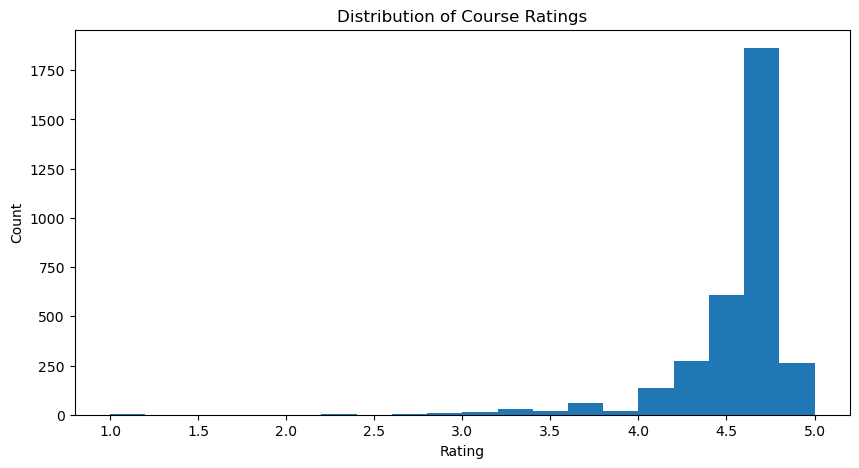

In [13]:
plt.figure(figsize=(10,5))
plt.hist(df['Course Rating'],bins=20)
plt.title('Distribution of Course Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [14]:
# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Content'])

# Dimensionality Reduction
svd = TruncatedSVD(n_components=50)
course_features = svd.fit_transform(tfidf_matrix)


In [15]:
# Simulate user preferences based on ratings
df['User Preference'] = df['Course Rating'] >= 4.5  # Assuming users prefer courses with ratings >= 4.5


In [16]:
X_train, X_test, y_train, y_test = train_test_split(course_features, df['User Preference'], test_size=0.2, random_state=42)


In [17]:
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression()

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)


LogisticRegression()

In [18]:
ensemble = VotingClassifier(estimators=[
    ('rf', model1), 
    ('lr', model2)],
    voting='soft')

ensemble.fit(X_train, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr', LogisticRegression())],
                 voting='soft')

In [19]:
predictions = ensemble.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, predictions))

Ensemble Accuracy: 0.7541729893778453


In [37]:
def recommend_courses(user_input, num_recommendations=5):
    # Create a new DataFrame for the user input
    df_new = pd.DataFrame({'Course Description': [user_input], 'Skills': [''], 'Course Rating': [0], 'Content': [user_input]})
    df_combined = pd.concat([df, df_new], ignore_index=True)

    # Create TF-IDF matrix for the combined DataFrame
    tfidf_matrix_new = tfidf_vectorizer.transform(df_combined['Content'])
    course_features_new = svd.transform(tfidf_matrix_new)

    # Compute cosine similarity between input and all course features
    similarity_scores = cosine_similarity(course_features_new[-1:], course_features_new[:-1])

    # Make predictions for all courses
    predictions_new = ensemble.predict(course_features_new[:-1])

    # Combine predictions with similarity scores and sort by similarity
    df_combined['Similarity'] = 0  # Initialize a similarity column
    df_combined.iloc[:-1, df_combined.columns.get_loc('Similarity')] = similarity_scores.flatten()
    df_combined['Prediction'] = 0  # Initialize a prediction column
    df_combined.iloc[:-1, df_combined.columns.get_loc('Prediction')] = predictions_new

    # Filter and sort recommended courses based on predictions and similarity
    recommended_courses_new = df_combined[df_combined['Prediction'] == 1].sort_values(by='Similarity', ascending=False)

    # Return top N recommendations
    return recommended_courses_new[['Course Name', 'University', 'Course URL', 'Course Rating']].head(num_recommendations)


In [38]:
user_input = input("Enter a course description: ")
recommended_courses=recommend_courses(user_input,num_recommendations=10)
recommended_courses

,Course Name,University,Course URL,Course Rating
581,Structuring Machine Learning Projects,DeepLearning.AI,https://www.coursera.org/learn/machine-learnin...,4.8
3248,Optimizing Machine Learning Performance,Alberta Machine Intelligence Institute,https://www.coursera.org/learn/optimize-machin...,4.5
3026,Machine Learning for All,University of London,https://www.coursera.org/learn/uol-machine-lea...,4.7
3112,Machine Learning Foundations: A Case Study App...,University of Washington,https://www.coursera.org/learn/ml-foundations,4.5
1388,Machine Learning with H2O Flow,Coursera Project Network,https://www.coursera.org/learn/machine-learnin...,4.8
2376,Explainable Machine Learning with LIME and H2O...,Coursera Project Network,https://www.coursera.org/learn/explainable-mac...,4.6
1281,Machine Learning with Python,IBM,https://www.coursera.org/learn/machine-learnin...,4.6
841,Machine Learning Algorithms: Supervised Learni...,Alberta Machine Intelligence Institute,https://www.coursera.org/learn/machine-learnin...,4.7
2065,Sample-based Learning Methods,University of Alberta,https://www.coursera.org/learn/sample-based-le...,4.7
266,Developing AI Applications on Azure,LearnQuest,https://www.coursera.org/learn/developing-ai-a...,4.3
